# Lane-detection

    参考尤达学城的课题LaneLines-P1-master and CarND-Advanced-Lane-Lines-master，
    进行添加灭点特征和平滑器，提高检测稳定性和结果可靠性，结合相似性函数提高车道线匹配稳定性，
    以下对代码进行说明，由于设计公司项目细节，只贴初版代码。
    
    
    **Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**
    **Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**
    `cv2.inRange()` for color selection  
    `cv2.fillPoly()` for regions selection  
    `cv2.line()` to draw lines on an image given endpoints  
    `cv2.addWeighted()` to coadd / overlay two images  
    `cv2.cvtColor()` to grayscale or change color  
    `cv2.imwrite()` to output images to file  
    `cv2.bitwise_and()` to apply a mask to an image  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math as ma
%matplotlib inline

## Some Useful Function

In [2]:
# SimularMeal，相似度度量函数，输入直线特征的斜率和与图像底边的交点x坐标值（类似点斜式），对比两直线区别（这里的系数需要调参）
def SimularMea1(k1,ex1,k2,ex2):
    delta_angle=abs(ma.atan(k1)-ma.atan(k2))*180/ma.pi
    delta_b_y=abs((ex1-960)*k1-(ex2-960)*k2)#960 induce the width of input img
    return delta_b_y/10 + delta_angle#value function1

# 待定，
def SimularMea2():
    return None

# getCrossPoint，函数用于求取两条直线的交点坐标，返回值为np.array([u,v])
def getCrossPoint(LineA, LineB):
    # calculate the k of line A/B
    ka = (LineA[3] - LineA[1]) / (LineA[2] - LineA[0])
    kb = (LineB[3] - LineB[1]) / (LineB[2] - LineB[0])

    crossPoint=[0,0] # (x,y)
    crossPoint[0] = (ka*LineA[0] - LineA[1] - kb*LineB[0] + LineB[1]) / (ka - kb)
    crossPoint[1] = (ka*kb*(LineA[0] - LineB[0]) + ka*LineB[1] - kb*LineA[1]) / (ka - kb)
    return np.array(crossPoint)

# disPL2，求point到line的直线距离
def disP2L(point,line):#line=[x1,x2,y1,y2]
    X1=line[0]
    Y1=line[1]
    X2=line[2]
    Y2=line[3]
    
    a=Y2-Y1
    b=X1-X2
    c=X2*Y1-X1*Y2
    dis=(ma.fabs(a*point[0]+b*point[1]+c))/(ma.pow(a*a+b*b,0.5))
    return dis

# CatchVanishP，求取灭点，基于已知直线，求其交点，再基于交点，通过聚类筛选出灭点
def CatchVanishP(lines,length):
    Clusterpoint=[[getCrossPoint(lines[0],lines[1])]]
    for i in range(0,length):
        for j in range(i+1,length):
            temppoint = getCrossPoint(lines[i],lines[j])
            tempid=0
            mindif=100
            for k in range(len(Clusterpoint)):
                temp=sum(abs(Clusterpoint[k][0]-temppoint))
                if temp < mindif:
                    mindif = temp
                    tempid=k
            if mindif==100:
                Clusterpoint.append([getCrossPoint(lines[i],lines[j])])
            else:
                Clusterpoint[tempid].append(getCrossPoint(lines[i],lines[j]))
    maxlen=0
    for points in Clusterpoint:
        lenth=len(points)
        if lenth>maxlen:
            maxlen=lenth
            point=np.mean(points,axis=0)
    return point

In [3]:
# 滚动平滑器，通过滚动平滑，不断更新记录的车道线，每条车道线保留window_size个数据，输出为平均值，
# 使车道线显示平滑更新，结果更稳定，鲁棒性更高。
class Smooth:
    def __init__(self, windowsize=10):
        # 初始化，window_size代表同一根车道线最多保留多少帧结果，实际输出为平均值！
        # index记录帧数，lenth记录有效车道数，threshold需要调参，time记录每条车道线的检测数，VP记录灭点像素坐标
        # data，保留window_size帧数据，最多10条车道线，每条车道线有4个参数
        self.window_size = windowsize
        self.data = np.zeros((self.window_size, 10, 4), dtype=np.float32)
        self.index = 0
        self.lenth = 0
        self.threshold = 300
        self.time = np.array([0,0,0,0,0,0,0,0,0,0],dtype=np.int8)
        self.VP = None
    
    def __iadd__(self, x):# 对接重载的+=操作
        if self.index == 0:
		# 初始化
            self.lenth = len(x)
            self.data[:,0:self.lenth] = x 
            self.time[0:self.lenth] = 2
        index = self.index % self.window_size
        
        # 当帧车道线与跟踪数据对比，判断是否属于，是则加入data中作为更新值，否则丢弃数据或者作为新跟踪目标；当有灭点时，
        # 判断是否经过灭点，去掉不经过的车道线；实时更新time值，>0为有效目标，否则无效；每3帧更新一次灭点和跟踪数目。
        for data in x:
            mindif = self.threshold
            tempid = 0
            for ID in range(self.lenth):
                Data = self.data[index][ID]
                temp = abs(data[0]-Data[0])# 另外构建SimularMea2代入
                if temp < mindif:
                    mindif = temp
                    tempid = ID
            if self.VP is not None:
                if disP2L(self.VP,data)>15:# 灭点到线距离，大于阈值15，则认为不经过灭点，需要调参。
                    continue                
            # 若未检测到，则增设为新的跟踪车道线，否则作为某条车道线在平滑器中记录的当帧更新值
            if mindif == self.threshold:
                self.data[:,self.lenth] = data
                self.time[self.lenth] = 3
                self.lenth += 1
            else:
                self.data[index][tempid] = data
                self.time[tempid] += 2
        self.time[self.time>0] -=1
		
		# 每3帧，计算一次灭点，剔除无效车道线。
        if self.index % 3 == 0:
            targetid=np.nonzero(self.time)
            templen=len(targetid[0])
            
            if templen != self.lenth:
                temp=self.data[:,targetid,:].mean(axis=0)
                self.data=np.zeros((self.window_size, 10, 4), dtype=np.float32)
                self.data[:,0:templen,:] = temp
                
                temp=self.time[targetid]
                self.time = np.array([0,0,0,0,0,0,0,0,0,0],dtype=np.int8)
                self.time[0:templen]=temp
            
                self.lenth=templen

            temp=self.data.mean(axis=0)
            if self.lenth >2:
                self.VP=CatchVanishP(temp,self.lenth)        
 
        self.index += 1
        return self

In [4]:
def grayscale(img):
    """Applies the Grayscale transform  This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale you should call plt.imshow(gray, cmap='gray')    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """ Applies an image mask. Only keeps the region of the image defined by the polygon formed from `vertices`. 
    The rest of the image is set to black. """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """ Draws `lines` with `color` and `thickness`. """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    # 基于houghLinesP的结果进行特征处理，转化直线特征成斜截式，基于相似度函数对直线进行分类，
    # 剔除数量过少的目标，把车道线均值传入平滑器
    
    # a为声明全局Smooth类，用法下文介绍
    global a
    
    # 预处理后的图像传入houghlinesP,完成hough变换
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros([img.shape[0], img.shape[1], 3], dtype=np.uint8)
    lines2 = []
    try:
	    # 遍历检测结果，根据k取值，筛选车道线结果
        for line in lines:
            for x1,y1,x2,y2 in line:
                if abs(y1-y2) < 10:#10
                    continue
                k = float(y2-y1)/(x2-x1)
                if abs(1/k)>5:
                    continue
                # 输出结果统一，转化为斜截式
                if y1 > y2:
                    extend = int(x2 + (height-y2)/k)
                    lines2.append([x2-x1, y2, k, extend])
                elif y1 < y2:
                    extend = int(x1 + (height-y1)/k)
                    lines2.append([x2-x1, y1, k, extend])
        lines3 = [[lines2[0]]]
        
		# 基于相似性函数，对车道线进行分类，把同一条车道线数据分成一类，这里需要调参mindif
        for j in range(len(lines2)):
            mindif=10
            tempid=0
            side=lines2[j]
            for ID in range(len(lines3)):
                temp = SimularMea1(lines3[ID][0][2],lines3[ID][0][3],side[2],side[3])# 相似度计算函数
                if temp < mindif:
                    mindif = temp
                    tempid = ID    
            if mindif > 7:
                lines3.append([side])
            else:
                lines3[tempid].append(side)
        
        # 基于分类结果，取平均值，得到lines4，并把结果传输给smooth，这里对+=操作重载操作
        lines4=[]
        for side in lines3:
            if len(side)<3:
                continue
            side=np.array(side)
            h2 = side[:, 1].min()
            side[:,0] /= side[:,0].min()
            k1 = np.average(side[:,2], weights=side[:,0])
            x1 = np.average(side[:,3], weights=side[:,0])
            lines4.append([int(x1), height, int(x1-(height-h2)/k1), int(h2)])
        a += np.array(lines4)
    except:
        pass
    # 从smooth中取出平滑结果，作为当帧输出。
    lines5 = a.data.mean(axis=0)
    draw_lines(line_img, [lines5], thickness=5)
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, a=0.8, b=1., c=0.):
    """ `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    result = initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, c)

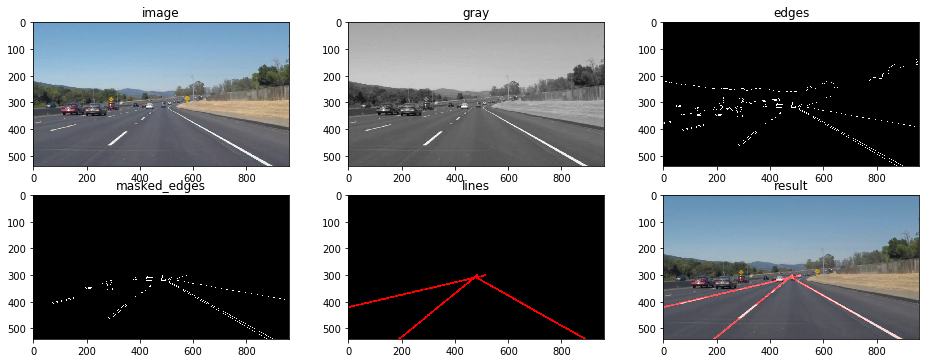

In [5]:
a = Smooth()
# image = cv2.imread('test_images/solidYellowCurve.jpg')
image = cv2.imread('test_images/solidWhiteCurve.jpg')
# image = cv2.imread('test_images/challenge.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height = image.shape[0]
width = image.shape[1]
interest = np.array([[0, height], [0,400], [width*3/8, height*5/9],
                     [width*5/8, height*5/9], [width,height*0.6], [width, height]], np.int32)

#canny
gray = grayscale(image)
blur_gray = gaussian_blur(gray,7)
edges = canny(blur_gray, 65, 170)
masked_edges = region_of_interest(edges,[interest])

#  img, rho, theta, threshold, min_line_len, max_line_gap
lines = hough_lines(masked_edges, 1, np.pi/180, 15, 1, 130)
result = weighted_img(image, lines, 0.9, 0.9)

def showimg(subplace, title, _img):
    plt.subplot(*subplace)
    plt.title(title)
    if len(_img.shape) == 3:
        plt.imshow(_img)
    else:
        plt.imshow(_img, cmap='gray')

plt.figure(figsize=[16, 9])
for i, imgname in enumerate(['image', 'gray', 'edges', 'masked_edges', 'lines', 'result']):
    showimg((3, 3, i+1), imgname, eval(imgname))

## Test on Videos

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    global height, width
    height = image.shape[0]
    width = image.shape[1]
    interest = np.array([[0, height], [0,400], [width*3/8, height*5/9],
                         [width*5/8, height*5/9], [width,height*0.6], [width, height]], np.int32)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray,7)
    edges = canny(blur_gray, 65, 170)
    masked_edges = region_of_interest(edges,[interest])

    #  img, rho, theta, threshold, min_line_len, max_line_gap
    lines = hough_lines(masked_edges, 1, np.pi/180, 15, 1, 130)
    result = weighted_img(image, lines, 0.9, 0.9)
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
a = Smooth(windowsize=5)
white_output = 'test_videos_output/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/white.mp4.
Moviepy - Writing video test_videos_output/white.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/white.mp4
Wall time: 2.95 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
a = Smooth(windowsize=5)

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 9.68 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
def process_image(image):
    #canny
    gray = grayscale(image)
    blur_gray = gaussian_noise(gray,7)
    edges = canny(blur_gray, 50, 150)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # define the region-of-interest
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]-70),(220, 400), (580, 400), (imshape[1],imshape[0]-70)]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)

    # Define the Hough transform parameters
    rho = 1                             # distance resolution in pixels of the Hough grid
    theta = np.pi/180                   # angular resolution in radians of the Hough grid
    threshold = 100                     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20                 # minimum number of pixels making up a line
    max_line_gap = 25                   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0       # creating a blank to draw lines on

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create the combined image, show and save it
    color_edges = np.dstack((edges, edges, edges)) 
    finalimg = weighted_img(line_image,image)
    return finalimg

In [13]:
a = Smooth(windowsize=5)

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 8.07 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))